## SESIÓN 4: APRENDIZAJE POR REFUERZO EN ENTORNOS DISCRETOS

**Carmen Miguel Spínola**

**Miguel Ángel Molina de la Rosa**

### CLIFFWALKING

In [22]:
import gymnasium as gym
problema = gym.make("CliffWalking-v0")
print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()
env=problema

Tamaño de espacio de estados Discrete(48)
Estado aleatorio 34
Hay 48  estados posibles.


In [23]:
# Primero se inicializa la Q-table a una matriz 48x4 (estados x número de acciones posibles) de ceros
env = gym.make("CliffWalking-v0")
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

#### Entrenamiento con parámetros fijos y las recompensas de gymnasium

Para este entrenamiento, se usan los siguientes valores para los hiperparámetros: 
- Velocidad de aprendizaje (alfa) = 0,8. Nos fiamos mucho de la nueva experiencia aprendida.
- Tasa de descuento (gamma) = 0,2. Importan más los refuerzos inmediatos que el largo plazo.
- Factor de exploración (epsilon) = 0,5. La probabilidad de realizar un movimiento aleatorio es igual que la probabilidad de eligir el movimiento 'mejor' según lo que hay en qtable en ese momento.

En cuanto a las recompensas, Gymnasium tiene por defecto:
- Recompensa de -1 para cualquier dirección que se tome (izquierda, derecha, arriba y abajo).
- Recompensa de -10 en caso de caer por el barranco que además supone una penalización.

In [24]:
"""Training the agent"""

import random
from IPython.display import clear_output

def trainAgent1():
    # Hyperparameters
    alpha = 0.8
    gamma = 0.2
    epsilon = 0.5
    episodes = 100000

    # For plotting metrics
    all_epochs = []
    all_penalties = []

    for i in range(1, episodes+1):
        state,_ = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info, _ = env.step(action) 
            
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")


In [25]:
%%time
q_table = np.zeros([env.observation_space.n, env.action_space.n])
trainAgent1()
print(q_table)

Episode: 100000
Training finished.

[[  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.24999999   -1.24999997   -1.24999997   -1.25      ]
 [  -1.24999997   -1.24999987   -1.24999987   -1.24999999]
 [  -1.24999987   -1.24999936   -1.24999936   -1.24999997]
 [  -1.24999936   -1.2499968    -1.2499968    -1.24999987]
 [  -1.2499968    -1.249984     -1.249984     -1.24999936]
 [  -1.249984     -1.24992      -1.24992      -1.2499968 ]
 [  -1.24992      -1.2496       -1.2496       -1.249984  ]
 [  -1.2496       -1.248        -1.248        -1.24992   ]
 [  -1.248        -1.248        -1.24         -1.2496    ]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.25         -1.24999997   -1.24999997   -1.25      ]
 [  -1.24999999   -1.24999987   -1.24999987   -1.24999999]
 [  -1.24999997   -1

Para entender la Q-table debemos saber que:
- Cada fila representa una casilla empezando por la esquina superior izquierda y se recorren hacia la derecha. Así, vemos como las 11 últimas filas tienen valores 0 ya que hacen referencia a las casillas que ocupa el barranco y, la última fila, a la meta.
- Cada columna representa uno de los 4 movimientos posibles en este orden: arriba, derecha, abajo e izquierda.

Con esto claro, analizamos los distintos valores de la tabla:
- Valores alrededor de -1.25: Se da en la mayoría de estados donde vemos que el agente encuentra movimientos poco penalizados (ya que las recompensas son negativas) que puede utilizar para encontrar el camino hacia la meta. 
    - Hay algunos valores que no son exactamente -1.25 y la penalización es algo menor. Esto se debe a que el agente se entrena para encontrar el camino más óptimo y estas ligeras diferencias harán que esto sea posible.

- Valores de -100.25: Se dan en acciones muy penalizadas ya que se produce la caída del agente por el acantilado. Se observan en los movimientos hacia abajo de las casillas de la penúltima fila y en el movimiento hacia la derecha en la casilla de salida. Estos valores tan negativos harán que el agente no contemple la posibilidad de elegir esas acciones.

- Valores de 0: Se dan en las casillas del barranco donde el agente está obligado a comenzar de nuevo y en la casilla de meta donde ya no hay recompensas en ninguna acción.

En cuanto al tiempo, el entrenamiento tarda 2 minutos y medio apróximadamente debido a que se dan 100 000 episodios. Más adelante estudiamos si es posible obtener el camino óptimo con menos episodios.

Comprobamos que resulve el problema siguiendo el camino más corto:

In [26]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames,time=.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(time)

In [27]:
def solveCliff(q_table,showF=False,time=.2):
     
    state,_= env.reset()
    epochs = 0
    penalties, reward = 0, 0
    reward = 0
    frames = [] # for animation
    done = False

    while not done:
        action = np.argmax(q_table[int(state)])
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        state, reward, done, info, _ = env.step(action)

        if reward == -10:
            penalties += 1

        

        epochs += 1
        
        if epochs >=1000:
            done = True


    print("Timesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    
    if (showF):
        print_frames(frames,time)        
    env.close()
    

In [28]:
%%time
env = gym.make("CliffWalking-v0",render_mode="ansi")
solveCliff(q_table,True)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T


Timestep: 13
State: 35
Action: 2
Reward: -1
CPU times: total: 0 ns
Wall time: 2.64 s


In [8]:
env.close()

Con estos valores para los hiperparámetros tenemos que se obtiene el camino más óptimo con 100 000 episodios de aprendizaje. A continuación, comprobaremos si se obtiene la solución con 5000 episodios sin modificar los valores de los hiperparámetros.

In [9]:
"""Training the agent"""

import random
from IPython.display import clear_output

def trainAgent2():
    # Hyperparameters
    alpha = 0.8
    gamma = 0.2
    epsilon = 0.5
    episodes = 5000 #modificamos el número de episodios

    # For plotting metrics
    all_epochs = []
    all_penalties = []

    for i in range(1, episodes+1):
        state,_ = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info, _ = env.step(action) 
            
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")


Observamos que los valores de la Q-Table son iguales que anteriormente.

In [10]:
%%time
q_table = np.zeros([env.observation_space.n, env.action_space.n])
trainAgent2()
print(q_table)

Episode: 5000
Training finished.

[[  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.24999999   -1.24999997   -1.24999997   -1.25      ]
 [  -1.24999997   -1.24999987   -1.24999987   -1.24999999]
 [  -1.24999987   -1.24999936   -1.24999936   -1.24999997]
 [  -1.24999936   -1.2499968    -1.2499968    -1.24999987]
 [  -1.2499968    -1.249984     -1.249984     -1.24999936]
 [  -1.249984     -1.24992      -1.24992      -1.2499968 ]
 [  -1.24992      -1.2496       -1.2496       -1.249984  ]
 [  -1.2496       -1.248        -1.248        -1.24992   ]
 [  -1.248        -1.248        -1.24         -1.2496    ]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.25         -1.24999997   -1.24999997   -1.25      ]
 [  -1.24999999   -1.24999987   -1.24999987   -1.24999999]
 [  -1.24999997   -1.2

In [11]:
env = gym.make("CliffWalking-v0",render_mode="ansi")
solveCliff(q_table,True)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T


Timestep: 13
State: 35
Action: 2
Reward: -1


In [12]:
env.close()

Obtenemos la resolución óptima del problema en 5000 episodios lo que nos será útil para análisis posteriores acortando tiempos de ejecución.

#### Entrenamiento con varios valores para los parámetros y las recompensas de gymnasium

Comprobamos cómo afecta al entrenamiento la modificación de los valores de los hiperparámetros y cuál es el mínimo tiempo (mínimo número de episodios) en el que podemos obtener la ruta óptima.

Episode: 5000


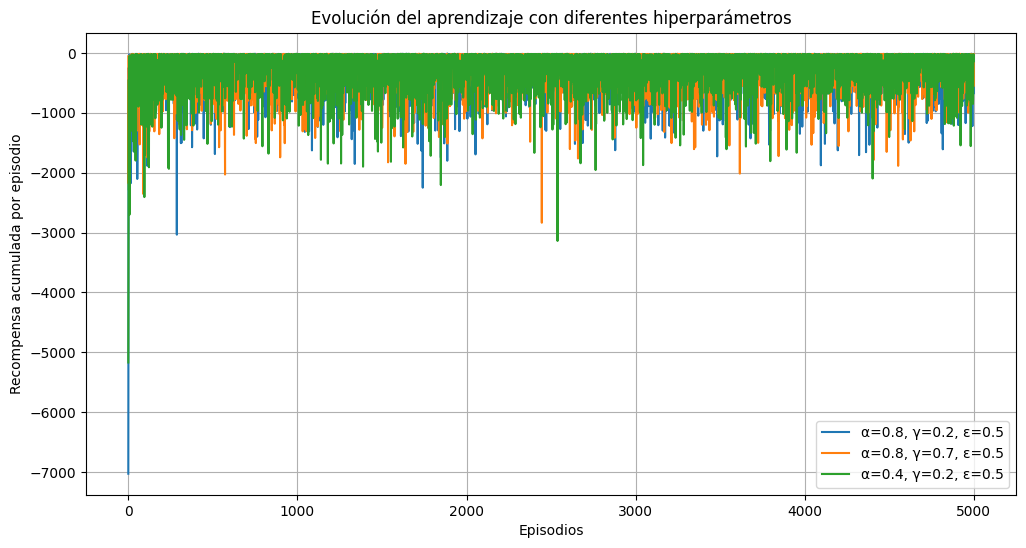

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def trainAgent(q_table, alpha, gamma, epsilon, episodes):
    rewards_per_episode = []
    
    for i in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploración
            else:
                action = np.argmax(q_table[state])  # Explotación

            next_state, reward, done, info, _ = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Actualiza la Q-value
            q_table[state, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

            total_reward += reward
            state = next_state

        rewards_per_episode.append(total_reward)  # Guarda la recompensa total del episodio

        # Mostrar progreso cada 100 episodios
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    return rewards_per_episode  # Retorna las recompensas por episodio

# Configura hiperparámetros para probar varias configuraciones
params = [
    (0.8, 0.2, 0.5), #Valores anteriores (referencia)
    (0.8, 0.7, 0.5), #Variamos gamma: más importancia al largo plazo
    (0.4, 0.2, 0.5), #Variamos alfa: menos importancia a la nueva experiencia
]

# Entrena y almacena los resultados
results = {}
for alpha, gamma, epsilon in params:
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    rewards = trainAgent(q_table, alpha, gamma, epsilon, 5000)
    results[(alpha, gamma, epsilon)] = rewards

# Grafica los resultados con líneas sólidas
plt.figure(figsize=(12, 6))
for (alpha, gamma, epsilon), rewards in results.items():
    plt.plot(rewards, linestyle='-', label=f"α={alpha}, γ={gamma}, ε={epsilon}")

plt.xlabel('Episodios')
plt.ylabel('Recompensa acumulada por episodio')
plt.title('Evolución del aprendizaje con diferentes hiperparámetros')
plt.legend()
plt.grid(True)
plt.show()


Se juega con los hiperparámetros alfa y gamma, manteniendo el factor de exploración a 0.5 (manteniendo un balance en la elección del agente entre escoger movimientos no explorados y fiarse de las recompensas que están en la tabla):
- Primer caso (α = 0.8; γ = 0.2): El valor de alfa cercano a 1 hace que se dé mucha importancia a la nueva experiencia y el valor de gamma cercano a 0 refuerza la importancia de los refuerzos inmediatos frente al largo plazo. Esto provoca que haya máximos en lugares muy dispersos de la gráfica y se acumulen recompensas negativas sin importar lo que se haya estudiado hasta el momento.
- Segundo caso (α = 0.8; γ = 0.7): Se modifica la tasa de descuento para que sea más importante el largo plazo. Al mantener la tasa de aprendizaje en 0.8 se acumulan muchas recompensas negativas sin hacer demasiado caso a lo que se tenía hasta el momento. Dar mucha importancia al largo plazo puede provocar que la recompensa acumulada en cierto episodio sea muy negativa si ese caso nos lleva posteriormente a una caída por el barranco. 
- Tercer caso (α = 0.4; γ = 0.2): Volvemos a reforzar las recompensas inmediatas reduciendo gamma y al disminuir alfa hacemos que se otorgue menos importancia a la nueva experiencia. Esto hace que las recompensas acumuladas por episodio sigan una tendencia ascendente (se acerca a 0 desde número negativos grandes) y no haya máximos tan pronunciados a medida que se avanza en el aprendizaje.

A continuación, probamos con distintos valores para epsilon:

Episode: 5000


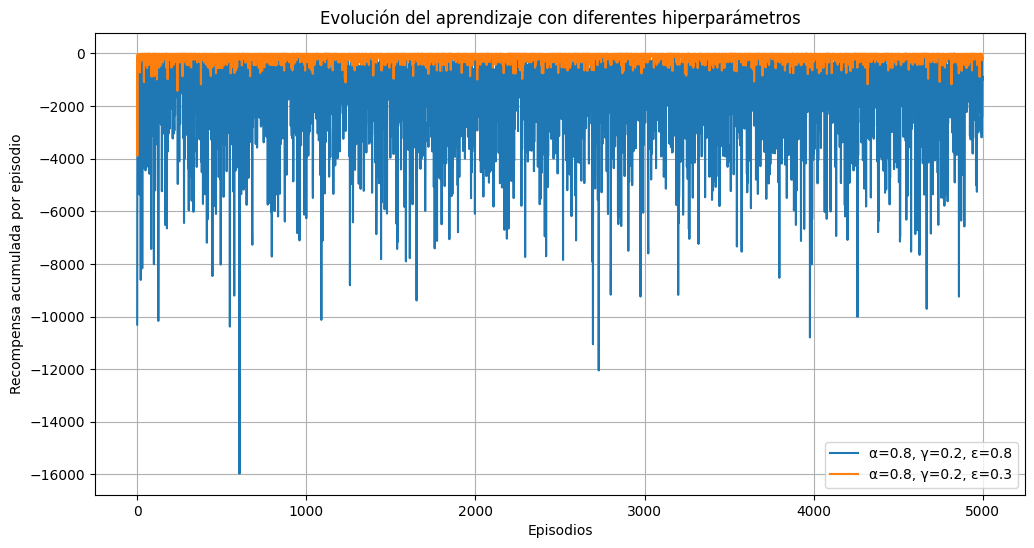

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def trainAgent(q_table, alpha, gamma, epsilon, episodes):
    rewards_per_episode = []
    
    for i in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploración
            else:
                action = np.argmax(q_table[state])  # Explotación

            next_state, reward, done, info, _ = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Actualiza la Q-value
            q_table[state, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

            total_reward += reward
            state = next_state

        rewards_per_episode.append(total_reward)  # Guarda la recompensa total del episodio

        # Mostrar progreso cada 100 episodios
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    return rewards_per_episode  # Retorna las recompensas por episodio

# Configura hiperparámetros para probar varias configuraciones
params = [
    (0.8, 0.2, 0.8), #Variamos epsilon: más aleatorio
    (0.8, 0.2, 0.3), #Variamos epsilon: menos aleatorio
    
]

# Entrena y almacena los resultados
results = {}
for alpha, gamma, epsilon in params:
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    rewards = trainAgent(q_table, alpha, gamma, epsilon, 5000)
    results[(alpha, gamma, epsilon)] = rewards

# Grafica los resultados con líneas sólidas
plt.figure(figsize=(12, 6))
for (alpha, gamma, epsilon), rewards in results.items():
    plt.plot(rewards, linestyle='-', label=f"α={alpha}, γ={gamma}, ε={epsilon}")

plt.xlabel('Episodios')
plt.ylabel('Recompensa acumulada por episodio')
plt.title('Evolución del aprendizaje con diferentes hiperparámetros')
plt.legend()
plt.grid(True)
plt.show()


- Primer caso (ε=0.3): La gráfica se mantiene más estable al elegir las acciones que el agente ya 'sabe' que funcionan mejor y la recompensa acumulada va creciendo hacia 0. Esto puede tener sus contras y puede provocar que queden estados sin estudiar, haciendo que no se llegue a la ruta más óptima.
- Segundo caso (ε=0.8): Se dan más acciones aleatorias y, como consecuencia, las recompensas acumuladas por epiosdio varían mucho y no tenemos una distribución tan estable aunque, de esta manera, nos aseguramos de analizar mayor número de acciones y de obtener la ruta óptima a base de prueba y error.

Se observa también que el tiempo de ejecución es mayor cuanto mayor es epsilon.


Probar con varios parámetros y hacer gráfica.

#### Modificación de las recompensas

Al ser un problema tan sencillo se puede hacer una pequeña modificación de las recompensas para conseguir que el aprendizaje sea más óptimo y se encuentre antes la ruta más corta hacia la meta. Teniendo que el agente parte de la esquina inferior izquierda y la meta se encuentra en la esquina inferior derecha, resulta obvio que el camino más corto hacia la meta se va a basar principalmente en movimientos a la derecha. Con esto, llegamos a al conclusión de que, con el fin de mejorar el aprendizaje, resulta óptimo penalizar los movimientos hacia la izquierda ya que, en este caso, no nos llevarán a la solución.

In [88]:
import gymnasium as gym
import numpy as np
import random
from IPython.display import clear_output

# Clase para ajustar las recompensas
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
    
    def step(self, action):
        next_state, reward, done, info, _ = self.env.step(action)
        
        # Modificar las recompensas
        if done and reward == -100:
            reward = -1000
        elif done:
            reward = 10
        else:
            reward = -1
            if action == 3:  # Penalización adicional si se mueve a la izquierda
                reward -= 1

        return next_state, reward, done, info, _

In [89]:
# Crear el entorno con las recompensas personalizadas
env = gym.make("CliffWalking-v0")
env = CustomRewardWrapper(env)

Se implementa un sistema de recompensas en el que:
- La penalización por caer por el barranco es de -1000.
- Se recompensa con 10 por llegar a la meta.
- Al buscar la ruta más corta, es necesario penalizar cada paso con -1. Adicionalmente, se penaliza con otro -1 si la acción elegida es moverse a la izquierda con lo que la penalización total del movimiento será de -2.

In [90]:
def trainAgentMod (ep,a, g ,q_table):
    # Hiperparámetros iniciales y decay
    alpha = a
    gamma = g
    epsilon = 0.7
    epsilon_decay = 0.9995
    min_epsilon = 0.01

    for i in range(1, ep + 1):
        state, _ = env.reset()
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, info, _ = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Actualización Q-learning
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state

        # Aplicar decay a los hiperparámetros
        epsilon = max(epsilon * epsilon_decay, min_epsilon)

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i} | Epsilon: {epsilon:.3f} | Alpha: {alpha:.3f} | Gamma: {gamma:.3f}")

    print("Training finished.\n")

Se hace uso del decay para que el programa vaya decreciendo el parámetro epsilon haciendo que al principio se priorice la exploración y, a medida que avanza el aprendizaje, se de más importancia a la explotación.

Se analizan las Q-Tables obtenidas para ver la variación respecto a las recompensas y cómo cambian según el valor de los parámetros:

In [94]:
import numpy as np

q_tablemod = np.zeros([env.observation_space.n, env.action_space.n])
#trainAgentMod(5000,0.8,0.8, q_tablemod)
#trainAgentMod(5000,0.8,0.4, q_tablemod)
#trainAgentMod(5000,0.4,0.8, q_tablemod)
trainAgentMod(5000,0.4,0.4, q_tablemod)
print(q_tablemod)

Episode: 5000 | Epsilon: 0.057 | Alpha: 0.400 | Gamma: 0.400
Training finished.

[[-1.66663535 -1.66658837 -1.66658837 -2.66663535]
 [-1.66658837 -1.66647093 -1.66647093 -2.66663535]
 [-1.66647093 -1.66617733 -1.66617733 -2.66658837]
 [-1.66617733 -1.66544333 -1.66544333 -2.66647093]
 [-1.66544333 -1.66360832 -1.66360832 -2.66617733]
 [-1.66360832 -1.6590208  -1.6590208  -2.66544333]
 [-1.6590208  -1.647552   -1.647552   -2.66360832]
 [-1.647552   -1.61888    -1.61888    -2.6590208 ]
 [-1.61888    -1.5472     -1.5472     -2.647552  ]
 [-1.5472     -1.368      -1.368      -2.61888   ]
 [-1.368      -0.92       -0.92       -2.5472    ]
 [-0.92       -0.92        0.2        -2.368     ]
 [-1.66663535 -1.66647093 -1.66647093 -2.66658837]
 [-1.66658837 -1.66617733 -1.66617733 -2.66658837]
 [-1.66647093 -1.66544333 -1.66544333 -2.66647093]
 [-1.66617733 -1.66360832 -1.66360832 -2.66617733]
 [-1.66544333 -1.6590208  -1.6590208  -2.66544333]
 [-1.66360832 -1.647552   -1.647552   -2.66360832]
 

Se varían los hiperparámetros alfa y gamma y se obtiene:
- Primer caso (α = 0.8; γ = 0.8): Teniendo la tasa de descuento cercana a 1, hacemos que los valores se propaguen más y se dé mayor importancia a largo plazo. Es por eso, que vemos valores positivos cercanos a la meta. Los valores de las zonas lejanas a la meta o que llevan a una caída son bajos o negativos. Con alfa a 0.8 estamos haciendo que el agente confíe mucho en la nueva experiencia y vaya aprendiendo en cada paso del aprendizaje.
- Segundo caso (α = 0.8; γ = 0.4): Reduciendo gamma vemos como los valores lejanos a la meta no están tan penalizados ya que las penalizaciones no se propagan tanto. De la misma forma pasa con las acciones cercanas a la meta, hay muchas menos celdas positivas y con valores menores, lo que evidencia esa menor propagación de las recompensas.
- Tercer caso (α = 0.4; γ = 0.8): Vemos como de nuevo se evidencia la propagación de las recompensas con un gamma alto. La tabla nos queda igual que en el primer caso a pesar de haber modificado alfa. Esto podría ser porque alfa es un parámetro que solo indica si aprendemos más de una experiencia actual o de lo sucedido anteriormente. Al tener el mismo valor de epsilon e ir decreciendo este de la misma manera, las recompensas se irán normalizando y al final solo se tomará lo aprendido en la nueva experiencia que dependerá fuertemente de lo que haya en la Qtable ya que estamos en fase de explotación con un epsilon ínfimo.
- Cuarto caso (α = 0.4; γ = 0.4): Se vuelve a perder ese efecto de propagación y tenemos una lista como en el segundo caso.

Se concluye que, con un valor de epsilon normalizado, el hiperparámetro con mayor impacto en los resultados es gamma y su variación da lugar a cambios importantes en las tablas. 

Además, la modificación de las recompensas queda plasmada en todos los casos ya que podemos ver que la última columna (relativa al movimiento a la izquierda) guarda mayor penalización que dado otro movimiento.

### BLACKJACK

In [40]:
import gymnasium as gym

problema = gym.make("Blackjack-v1")

print("Tamaño de espacio de observación:", problema.observation_space)
print("Estado aleatorio:", problema.observation_space.sample())
print("El espacio de observación es una tupla con 3 valores: (suma de cartas, carta visible del dealer, si tiene un As usable)")
estado, _ = problema.reset()
print("Estado inicial:", estado)
env = problema


Tamaño de espacio de observación: Tuple(Discrete(32), Discrete(11), Discrete(2))
Estado aleatorio: (np.int64(13), np.int64(8), np.int64(0))
El espacio de observación es una tupla con 3 valores: (suma de cartas, carta visible del dealer, si tiene un As usable)
Estado inicial: (10, 10, 0)


En el entorno de Blackjack, el espacio de observación no es discreto, sino que es una tupla que representa tres valores: la suma de las cartas del jugador, la carta visible del dealer y si el jugador tiene un As usable. Debido a esta estructura, no podemos crear una matriz Q directamente basada en el número de estados posibles como en el entorno de CliffWalking. En lugar de eso, necesitamos usar una estructura de datos que pueda manejar el espacio de observación como un conjunto de claves __(diccionarios)__

In [41]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

env = gym.make("Blackjack-v1")
q_table = defaultdict(lambda: np.zeros(env.action_space.n))
# El estado en Blackjack es una tupla: (suma de cartas del jugador, carta visible del dealer, si tiene As usable)
estado = (15, 10, False)  # Ejemplo de un estado
print("Valor Q inicial para el estado", estado, ":", q_table[estado])



Valor Q inicial para el estado (15, 10, False) : [0. 0.]


q_table se inicializa como un diccionario con listas de ceros para cada estado observado.

#### Entrenamiento con parámetros fijos y las recompensas de gymnasium

#### Parámetros de entrenamiento

- __Velocidad de aprendizaje (alfa)__ = 0.8: confiamos mucho en la nueva experiencia aprendida.
- __Tasa de descuento (gamma)__ = 0.2: damos más importancia a las recompensas inmediatas.
- __Factor de exploración (epsilon)__ = 0.5: hay una probabilidad igual de realizar una acción aleatoria y de elegir la acción “mejor” en función de la Q-table actual

#### Recompensas en Blackjack

En Blackjack, las recompensas predeterminadas son:

- __+1__ si el agente gana la partida,
- __0__ si empata,
- __-1__ si pierde


In [42]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
from IPython.display import clear_output

# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1")

# Inicializar la Q-table como un diccionario para cada estado observado
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

def train_agent_blackjack():
    # Hiperparámetros
    alpha = 0.8
    gamma = 0.2
    epsilon = 0.5
    episodes = 100000

    # Para almacenar métricas de rendimiento
    all_epochs = []
    all_penalties = []

    for i in range(1, episodes + 1):
        state, _ = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False

        while not done:
            # Selección de acción: Explorar o explotar
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explorar el espacio de acción
            else:
                action = np.argmax(q_table[state])  # Explorar valores aprendidos

            # Ejecutar la acción en el entorno y obtener el resultado
            next_state, reward, done, trunc, info = env.step(action)

            # Actualizar Q-table
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state][action] = new_value

            # Penalizar si la recompensa es negativa (perdió la partida)
            if reward == -1:
                penalties += 1

            state = next_state
            epochs += 1

        # Imprimir progreso cada 1000 episodios
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Entrenamiento finalizado.\n")


In [43]:
%%time
train_agent_blackjack()

# Imprimir la Q-table
for state, actions in q_table.items():
    print(f"Estado: {state}, Valores Q: {actions}")

Episode: 100000
Entrenamiento finalizado.

Estado: (16, 1, 1), Valores Q: [-1.00121036 -0.03390675]
Estado: (14, 10, 0), Valores Q: [-0.43831428  0.15347718]
Estado: (21, 2, 1), Valores Q: [ 1.25       -0.09685957]
Estado: (5, 1, 0), Valores Q: [-1.03776323 -0.02252933]
Estado: (16, 1, 0), Valores Q: [-1.04451854 -0.97251749]
Estado: (24, 1, 0), Valores Q: [0. 0.]
Estado: (13, 1, 1), Valores Q: [-1.00405517 -0.01527985]
Estado: (12, 1, 0), Valores Q: [-1.04644888 -0.09569353]
Estado: (15, 3, 1), Valores Q: [0.73608137 0.07718833]
Estado: (12, 2, 1), Valores Q: [1.21975434 0.09798947]
Estado: (20, 10, 1), Valores Q: [1.22929283 0.06384506]
Estado: (18, 10, 0), Valores Q: [-1.03053513 -0.99829575]
Estado: (18, 2, 0), Valores Q: [ 0.45027347 -0.9917148 ]
Estado: (9, 8, 0), Valores Q: [-0.57272045  0.04010098]
Estado: (21, 10, 1), Valores Q: [1.24825857 0.11257448]
Estado: (10, 4, 0), Valores Q: [-0.93874082  0.14004131]
Estado: (14, 4, 0), Valores Q: [-1.04855321 -0.79720693]
Estado: (15,

#### Estructura de la Q-table en Blackjack
__Cada fila__ representa un estado específico en el formato (suma de cartas del jugador, carta visible del dealer, si tiene un As usable).

__Cada columna__ representa una acción, donde:

- La primera columna (Valores Q[0]) corresponde a la acción de "Pedir carta".
- La segunda columna (Valores Q[1]) corresponde a la acción de "Plantarse".

#### Análisis de los valores en la Q-table
- __Valores positivos cercanos a 1__: indican que el agente ha aprendido que en esos estados hay una alta probabilidad de ganar tomando esa acción. Esto sucede en estados con combinaciones de cartas fuertes que probablemente lleven al agente a ganar la partida.
- __Valores negativos cercanos a -1__: representan estados en los que el agente ha encontrado que esa acción tiende a conducir a una derrota.
- __Valores cercanos a 0__: son estados en los que el agente no tiene suficiente información o en los que las recompensas esperadas son neutras, como en situaciones de empate.

En cuanto al tiempo, el entrenamiento tarda 22 segundos apróximadamente debido a que se dan 100 000 episodios. Más adelante estudiamos si es posible obtener el camino óptimo con menos episodios.

Comprobamos que resulve el problema siguiendo el camino más cort

In [44]:
from IPython.display import clear_output
from time import sleep

def print_blackjack_frames(frames, time=0.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print("Blackjack Frame:")
        print(f"Timestep: {i + 1}")
        
        # Estado detallado de Blackjack
        state = frame['state']
        print(f"State: Suma de cartas del jugador = {state[0]}, Carta visible del dealer = {state[1]}, As usable = {state[2]}")
        
        # Acción realizada
        action = frame['action']
        action_text = "Pedir carta" if action == 0 else "Plantarse"
        print(f"Action: {action_text}")
        
        # Recompensa obtenida
        print(f"Reward: {frame['reward']}")
        
        sleep(time)


In [45]:
import gymnasium as gym
import numpy as np


env = gym.make("Blackjack-v1")

def solve_blackjack(q_table, show_frames=False, time=0.2):
    state, _ = env.reset()
    epochs = 0
    total_reward = 0
    frames = []  # Para almacenar cada paso del juego
    done = False

    while not done:
        # Selecciona la mejor acción según la Q-table
        action = np.argmax(q_table[tuple(state)])

        # Guardar el estado actual en frames para la visualización
        frames.append({
            'frame': f"Suma de cartas del jugador: {state[0]}, Carta visible del dealer: {state[1]}, As usable: {state[2]}",
            'state': state,
            'action': action,
            'reward': total_reward
        })

        # Ejecuta la acción y observa el siguiente estado y recompensa
        next_state, reward, done, trunc, info = env.step(action)
        
        # Actualiza el total de recompensas
        total_reward += reward

        # Mover al siguiente estado
        state = next_state
        epochs += 1

        # Evitar que el bucle se prolongue indefinidamente
        if epochs >= 1000:
            done = True

    print("Timesteps taken:", epochs)
    print("Total reward:", total_reward)

    if show_frames:
        print_blackjack_frames(frames, time)

    env.close()


In [49]:
%%time
solve_blackjack(q_table, show_frames=True)

Blackjack Frame:
Timestep: 1
State: Suma de cartas del jugador = 14, Carta visible del dealer = 8, As usable = 0
Action: Pedir carta
Reward: 0
CPU times: total: 31.2 ms
Wall time: 204 ms


In [ ]:
env.close()

Para comprobar si el agente puede aprender una política efectiva en Blackjack con solo 5,000 episodios, mantendremos los mismos hiperparámetros que usaron en el entrenamiento de 100,000 episodios. La meta es ver si el agente puede alcanzar un rendimiento similar en menos tiempo.

In [50]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
from IPython.display import clear_output

# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1")

# Inicializar la Q-table como un diccionario para cada estado observado
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

def train_agent_blackjack():
    # Hiperparámetros
    alpha = 0.8
    gamma = 0.2
    epsilon = 0.5
    episodes = 5000

    # Para almacenar métricas de rendimiento
    all_epochs = []
    all_penalties = []

    for i in range(1, episodes + 1):
        state, _ = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False

        while not done:
            # Selección de acción: Explorar o explotar
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explorar el espacio de acción
            else:
                action = np.argmax(q_table[state])  # Explorar valores aprendidos

            # Ejecutar la acción en el entorno y obtener el resultado
            next_state, reward, done, trunc, info = env.step(action)

            # Actualizar Q-table
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state][action] = new_value

            # Penalizar si la recompensa es negativa (perdió la partida)
            if reward == -1:
                penalties += 1

            state = next_state
            epochs += 1

        # Imprimir progreso cada 1000 episodios
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Entrenamiento finalizado.\n")


In [51]:
%%time
train_agent_blackjack()

# Imprimir la Q-table
for state, actions in q_table.items():
    print(f"Estado: {state}, Valores Q: {actions}")

Episode: 5000
Entrenamiento finalizado.

Estado: (20, 6, 0), Valores Q: [ 1.24507767 -0.9999872 ]
Estado: (18, 10, 0), Valores Q: [-1.00574726  0.156137  ]
Estado: (14, 2, 0), Valores Q: [-0.86621955  0.0481143 ]
Estado: (13, 4, 0), Valores Q: [-0.4556816  -0.09840004]
Estado: (19, 6, 0), Valores Q: [ 0.14878401 -0.999936  ]
Estado: (20, 9, 1), Valores Q: [0.72090342 0.17884924]
Estado: (20, 9, 0), Valores Q: [ 0.4499415 -0.9999872]
Estado: (7, 1, 0), Valores Q: [0.61319803 0.02707307]
Estado: (18, 1, 1), Valores Q: [0.8 0. ]
Estado: (20, 1, 0), Valores Q: [ 1.02899978 -1.        ]
Estado: (19, 10, 1), Valores Q: [-0.86526776 -0.19904819]
Estado: (8, 10, 0), Valores Q: [-0.98781639  0.06647676]
Estado: (5, 3, 0), Valores Q: [-0.8         0.19210376]
Estado: (12, 5, 1), Valores Q: [-0.8         0.11047059]
Estado: (14, 10, 0), Valores Q: [-1.00044226 -0.22910593]
Estado: (24, 10, 0), Valores Q: [0. 0.]
Estado: (8, 9, 0), Valores Q: [-1.01145532 -0.04021058]
Estado: (15, 2, 0), Valores Q

Con 100,000 episodios, la Q-table muestra una notable mejora en consistencia y precisión en comparación con la de 5,000 episodios. Los valores de Q en estados clave presentan menor variabilidad y mayor optimización, lo que indica una estrategia más consolidada y menos dependiente de la exploración aleatoria. En muchos estados, los valores Q ahora reflejan decisiones más precisas, con una clara preferencia por las acciones óptimas y un rechazo de las subóptimas, algo que se traduce en un aprendizaje más estable. Además, muchos estados críticos tienen valores cercanos a cero o exactos, lo que sugiere que el agente ha tenido suficiente tiempo para explorar exhaustivamente y determinar los resultados a largo plazo en cada estado.

In [52]:
%%time
solve_blackjack(q_table, show_frames=True)

Blackjack Frame:
Timestep: 2
State: Suma de cartas del jugador = 18, Carta visible del dealer = 10, As usable = 0
Action: Plantarse
Reward: 0.0
CPU times: total: 0 ns
Wall time: 406 ms


In [53]:
env.close()

#### Entrenamiento con varios valores para los parámetros y las recompensas de gymnasium

Comprobamos cómo afecta al entrenamiento la modificación de los valores de los hiperparámetros y cuál es el mínimo tiempo (mínimo número de episodios) en el que podemos obtener la ruta óptima.

Episode: 100000 - Average Reward (last 100): -0.44


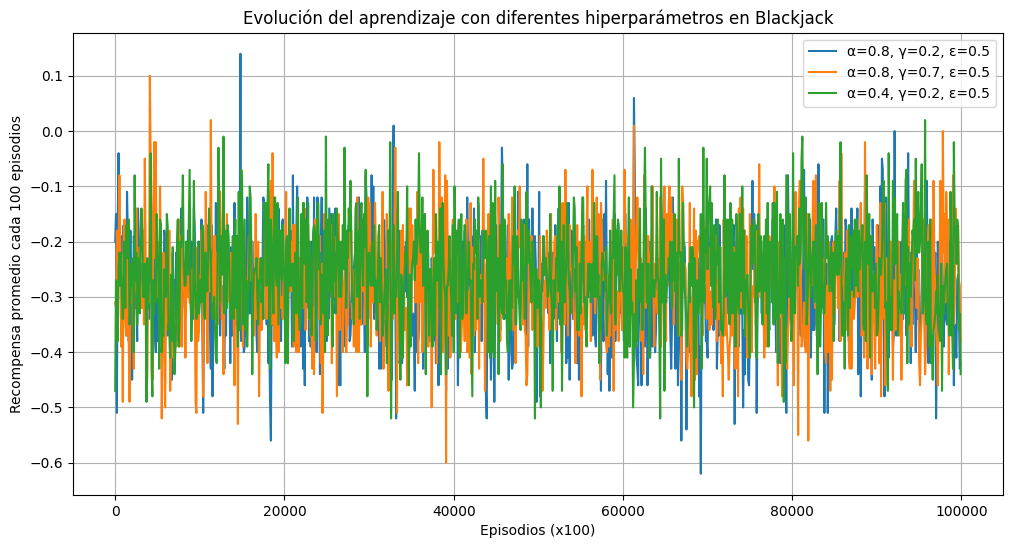

In [57]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Función para entrenar el agente en el entorno de Blackjack
def trainAgent(q_table, alpha, gamma, epsilon, episodes):
    rewards_per_100_episodes = []
    total_rewards = 0  # Para acumular recompensas cada 100 episodios
    
    for i in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Decidir si explora o explota
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploración
            else:
                action = np.argmax(q_table[state])  # Explotación

            # Ejecuta la acción y recibe el siguiente estado y recompensa
            next_state, reward, done, trunc, info = env.step(action)
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])

            # Actualiza la Q-value usando la ecuación de Bellman
            q_table[state][action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

            total_reward += reward
            state = next_state

        # Sumar la recompensa del episodio al total para calcular el promedio después
        total_rewards += total_reward

        # Cada 100 episodios, promediamos las recompensas y almacenamos el resultado
        if i % 100 == 0:
            average_reward = total_rewards / 100  # Promedio de los últimos 100 episodios
            rewards_per_100_episodes.append(average_reward)
            total_rewards = 0  # Reiniciar el acumulador para los próximos 100 episodios

            clear_output(wait=True)
            print(f"Episode: {i} - Average Reward (last 100): {average_reward}")

    return rewards_per_100_episodes  # Retorna las recompensas promediadas cada 100 episodios

# Configura hiperparámetros para probar varias configuraciones
params = [
    (0.8, 0.2, 0.5), #Valores anteriores (referencia)
    (0.8, 0.7, 0.5), #Variamos gamma: más importancia al largo plazo
    (0.4, 0.2, 0.5), #Variamos alfa: menos importancia a la nueva experiencia
]

# Entrena y almacena los resultados para cada conjunto de parámetros
results = {}
for alpha, gamma, epsilon in params:
    # Inicialización de la Q-table como un diccionario de tres tuplas, específico para Blackjack
    q_table = np.zeros((32, 11, 2, env.action_space.n))  # Representa estados y acciones en Blackjack
    rewards = trainAgent(q_table, alpha, gamma, epsilon, 100000)
    results[(alpha, gamma, epsilon)] = rewards

# Graficar los resultados promediados cada 100 episodios
plt.figure(figsize=(12, 6))
for (alpha, gamma, epsilon), rewards in results.items():
    plt.plot(range(0, 100000, 100), rewards, linestyle='-', label=f"α={alpha}, γ={gamma}, ε={epsilon}")

plt.xlabel('Episodios (x100)')
plt.ylabel('Recompensa promedio cada 100 episodios')
plt.title('Evolución del aprendizaje con diferentes hiperparámetros en Blackjack')
plt.legend()
plt.grid(True)
plt.show()


Se experimenta con los hiperparámetros alfa y gamma, manteniendo el factor de exploración en 0.5 (para balancear la elección del agente entre explorar nuevas acciones y explotar las recompensas conocidas en la Q-table):

- __Primer caso (α = 0.8; γ = 0.2)__: El valor alto de alfa (0.8) da gran importancia a las nuevas experiencias, mientras que el valor bajo de gamma (0.2) hace que se prioricen las recompensas inmediatas en lugar de las de largo plazo. Esto provoca mucha variabilidad en las recompensas, con máximos y mínimos dispersos. Las recompensas acumuladas se mantienen en el rango negativo, lo cual sugiere que el agente podría estar tomando decisiones subóptimas basadas en recompensas inmediatas sin una estrategia consistente a largo plazo.

- __Segundo caso (α = 0.8; γ = 0.7)__: Con un valor de gamma más alto (0.7), el agente se enfoca más en maximizar las recompensas a largo plazo. Sin embargo, al mantener alfa en 0.8, se da demasiada importancia a la experiencia reciente, lo cual puede hacer que el agente ajuste su comportamiento constantemente sin consolidar lo aprendido. Esto resulta en una alta variabilidad en las recompensas acumuladas, con episodios que a veces presentan mejoras, pero en general se mantienen en el rango negativo, indicando que el agente no logra obtener una estrategia ganadora de manera consistente.

- __Tercer caso (α = 0.4; γ = 0.2)__: Al reducir alfa a 0.4, el agente otorga menos peso a las nuevas experiencias, mientras que un gamma bajo refuerza las recompensas inmediatas. Esto permite que el agente aprenda de manera más estable, sin cambios bruscos. La gráfica muestra menos variabilidad en las recompensas acumuladas, y aunque las recompensas aún son negativas, se observa una tendencia más estable. Este enfoque parece permitir al agente seguir una estrategia más consistente en el corto plazo, aunque aún podría requerir ajustes para mejorar su rendimiento general en el Blackjack.

A continuación, probamos con distintos valores para epsilon:

Episode: 100000 - Average Reward (last 100): -0.26


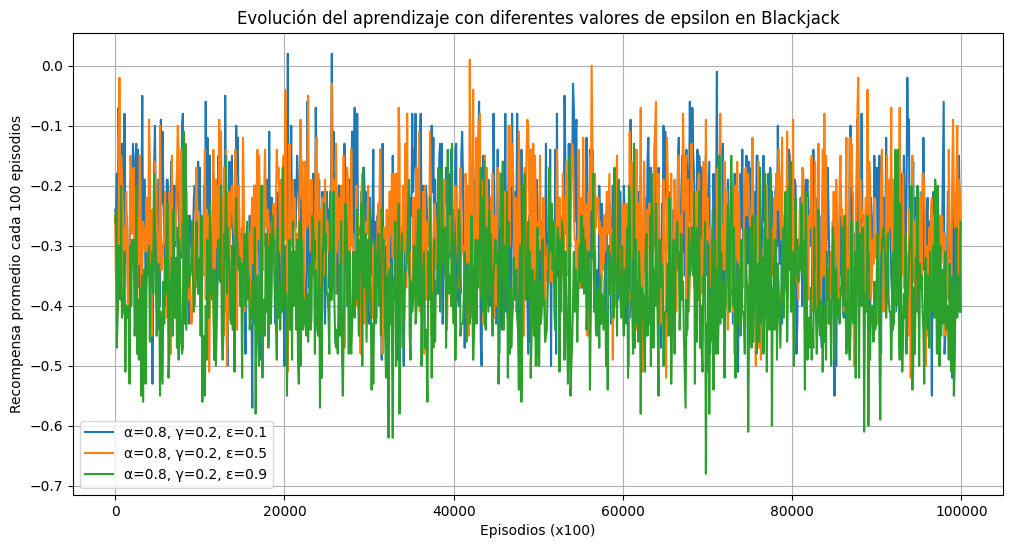

In [58]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Función para entrenar el agente en el entorno de Blackjack
def trainAgent(q_table, alpha, gamma, epsilon, episodes):
    rewards_per_100_episodes = []
    total_rewards = 0  # Para acumular recompensas cada 100 episodios
    
    for i in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Decidir si explora o explota
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploración
            else:
                action = np.argmax(q_table[state])  # Explotación

            # Ejecuta la acción y recibe el siguiente estado y recompensa
            next_state, reward, done, trunc, info = env.step(action)
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])

            # Actualiza la Q-value usando la ecuación de Bellman
            q_table[state][action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

            total_reward += reward
            state = next_state

        # Sumar la recompensa del episodio al total para calcular el promedio después
        total_rewards += total_reward

        # Cada 100 episodios, promediamos las recompensas y almacenamos el resultado
        if i % 100 == 0:
            average_reward = total_rewards / 100  # Promedio de los últimos 100 episodios
            rewards_per_100_episodes.append(average_reward)
            total_rewards = 0  # Reiniciar el acumulador para los próximos 100 episodios

            clear_output(wait=True)
            print(f"Episode: {i} - Average Reward (last 100): {average_reward}")

    return rewards_per_100_episodes  # Retorna las recompensas promediadas cada 100 episodios

# Configura hiperparámetros para probar varias configuraciones de epsilon
params = [
    (0.8, 0.2, 0.1), # Baja exploración
    (0.8, 0.2, 0.5), # Exploración moderada
    (0.8, 0.2, 0.9), # Alta exploración
]

# Entrena y almacena los resultados para cada conjunto de parámetros
results = {}
for alpha, gamma, epsilon in params:
    # Inicialización de la Q-table como un diccionario de tres tuplas, específico para Blackjack
    q_table = np.zeros((32, 11, 2, env.action_space.n))  # Representa estados y acciones en Blackjack
    rewards = trainAgent(q_table, alpha, gamma, epsilon, 100000)
    results[(alpha, gamma, epsilon)] = rewards

# Graficar los resultados promediados cada 100 episodios
plt.figure(figsize=(12, 6))
for (alpha, gamma, epsilon), rewards in results.items():
    plt.plot(range(0, 100000, 100), rewards, linestyle='-', label=f"α={alpha}, γ={gamma}, ε={epsilon}")

plt.xlabel('Episodios (x100)')
plt.ylabel('Recompensa promedio cada 100 episodios')
plt.title('Evolución del aprendizaje con diferentes valores de epsilon en Blackjack')
plt.legend()
plt.grid(True)
plt.show()


- __Epsilon = 0.1__: Baja exploración, el agente se enfoca principalmente en explotar lo que ya conoce, basándose en las recompensas acumuladas hasta el momento. Esto debería llevar a decisiones más consistentes pero podría evitar que el agente descubra mejores opciones.

- __Epsilon = 0.5__: Exploración moderada, el agente mantiene un equilibrio entre explorar nuevas acciones y explotar las recompensas conocidas, lo que debería permitir un balance en el aprendizaje.

- __Epsilon = 0.9__: Alta exploración, el agente frecuentemente elige acciones aleatorias, lo que permite explorar el espacio de acciones más a fondo. Esto puede ser útil en las primeras etapas del aprendizaje, pero podría generar inestabilidad en la recompensa promedio.

#### Modificación de las recompensas


Dado que el objetivo en Blackjack es maximizar la suma de las cartas del jugador sin superar los 21 puntos, podemos realizar una pequeña modificación en las recompensas para optimizar el aprendizaje y ayudar al agente a encontrar la mejor estrategia más rápidamente. Como es clave que el agente se acerque a 21 sin pasarse, podríamos penalizar las acciones que lo lleven a "pasarse" o superar 21, ya que esto implica una pérdida automática en el juego.

Así, podríamos otorgar recompensas positivas cuando el agente se acerca a 21 sin pasarse y, en cambio, asignar penalizaciones más altas para
las acciones que lo llevan a pasarse de 21

In [60]:
import gymnasium as gym
import numpy as np
import random
from IPython.display import clear_output

# Clase para ajustar las recompensas en Blackjack
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
    
    def step(self, action):
        next_state, reward, done, info, _ = self.env.step(action)
        player_sum, dealer_card, usable_ace = next_state  # Desempaquetar el estado

        # Modificar las recompensas para mejorar el aprendizaje en Blackjack
        if done:
            if player_sum > 21:
                reward = -10  # Penalización alta por pasarse de 21
            elif player_sum == 21:
                reward = 20  # Bonificación alta por alcanzar 21 sin pasarse
            elif player_sum < 21 and player_sum >= 17:
                reward = 5  # Recompensa moderada por plantarse en una mano alta (17-20)
            else:
                reward = -1  # Penalización leve para manos bajas
        else:
            # Pequeña penalización para incentivar decisiones estratégicas
            reward = -0.5

        return next_state, reward, done, info, _

In [61]:

# Crear el entorno y aplicar el wrapper de recompensas personalizadas
env = gym.make('Blackjack-v1', render_mode="human")
env = CustomRewardWrapper(env)

- __Penalización al pasarse de 21__: Se otorga una penalización alta de -10 cuando el agente "se pasa" de 21, para desalentar esta acción.
- __Bonificación al alcanzar 21__: Se otorga una bonificación de 20 cuando el agente alcanza exactamente 21 puntos, incentivando la acción óptima.
- __Recompensa por valores altos (17-20)__: Se otorga una recompensa moderada de 5 si el agente se planta en una mano alta que tiene una probabilidad aceptable de ganar.
- __Penalización leve para manos bajas__: Se asigna una penalización leve de -1 para manos bajas, incentivando al agente a mejorar su mano.
- __Penalización adicional durante el juego__: Cuando el episodio aún no ha terminado, se aplica una pequeña penalización de -0.5 para motivar al agente a -acercarse al objetivo en menos pasos.

In [62]:
def trainAgentMod(ep, a, g, q_table):
    # Hiperparámetros iniciales y decay
    alpha = a
    gamma = g
    epsilon = 0.7
    epsilon_decay = 0.9995
    min_epsilon = 0.01

    for i in range(1, ep + 1):
        state, _ = env.reset()
        done = False

        while not done:
            # Decisión de exploración o explotación
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploración
            else:
                action = np.argmax(q_table[state])  # Explotación

            # Realizar la acción y recibir nueva información del entorno
            next_state, reward, done, trunc, info = env.step(action)
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])

            # Actualización Q-learning
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state][action] = new_value

            # Actualizar el estado actual
            state = next_state

        # Aplicar decay a epsilon
        epsilon = max(epsilon * epsilon_decay, min_epsilon)

        # Mostrar progreso cada 100 episodios
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i} | Epsilon: {epsilon:.3f} | Alpha: {alpha:.3f} | Gamma: {gamma:.3f}")

    print("Entrenamiento finalizado.\n")


Se hace uso del decay para que el programa vaya decreciendo el parámetro epsilon haciendo que al principio se priorice la exploración y, a medida que avanza el aprendizaje, se de más importancia a la explotación.

Se analizan las Q-Tables obtenidas para ver la variación respecto a las recompensas y cómo cambian según el valor de los parámetros:

In [ ]:
# Configuración de combinaciones de parámetros alpha y gamma
param_combinations = [
    (0.8, 0.8),  # Configuración 1
    (0.8, 0.4),  # Configuración 2
    (0.4, 0.8),  # Configuración 3
    (0.4, 0.4)   # Configuración 4
]

# Entrenar y mostrar resultados para cada combinación de parámetros
for alpha, gamma in param_combinations:
    # Reiniciar la Q-table como un defaultdict para cada combinación
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Entrenar el agente con la combinación actual
    print(f"\nEntrenando con α={alpha}, γ={gamma}")
    trainAgentMod(ep=5000, a=alpha, g=gamma, q_table=q_table)
    
    # Imprimir una muestra de la Q-table resultante
    print(f"Q-table con α={alpha}, γ={gamma}:")
    # Mostrar solo los primeros valores para no saturar la salida
    for state, actions in list(q_table.items())[:10]:
        print(f"Estado: {state}, Valores Q: {actions}")